In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from MonteCarloTorusSWAP import RandomConfigSWAP, LocateParticlesSWAP, \
    StepOneSWAPRandom, AssignOrderSWAP, UpdateOrderSWAP, TrackParticleMoves, InsideRegion, \
    AssignOrderSwap, InsideRegion

# Plotting

In [2]:
def PlotCopy(R, Lx, Ly, region_geometry, boundary, step_size, ax, color):
    if region_geometry == 'strip':
        ax.hlines(y=boundary, xmin=0, xmax=Lx, color='red')
    elif region_geometry == 'circle':
        circle = plt.Circle((Lx/2, Ly/2), boundary, edgecolor='red', facecolor='none')
        ax.add_patch(circle)

    ax.set_xlim(0,Lx)
    ax.set_ylim(0,Ly)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.hlines(y=np.imag(R), xmin=(np.real(R)-step_size), xmax=(np.real(R)+step_size), color='gray', linestyles='--')
    ax.vlines(x=np.real(R), ymin=(np.imag(R)-step_size), ymax=(np.imag(R)+step_size), color='gray', linestyles='--')
    ax.scatter(np.real(R), np.imag(R), s=14, color=color)
    for i in range(R.size):
        ax.text(np.real(R[i]), np.imag(R[i]), str(i))

In [3]:
def PlotSWAP(R, swap_order, Lx, Ly, boundary, step_size, ax, colors):
    for i in range(ax.size):
        ax[i].fill_between(x=[0,Lx], y1=np.zeros(2), y2=np.ones(2)*step_size, color='gray', alpha=0.5)
        ax[i].fill_between(x=[0,Lx], y1=np.ones(2)*(boundary-step_size), y2=np.ones(2)*(boundary+step_size), color='gray', alpha=0.5)
        ax[i].fill_between(x=[0,Lx], y1=np.ones(2)*(Ly-step_size), y2=np.ones(2)*Ly, color='gray', alpha=0.5)
        ax[i].hlines(y=boundary, xmin=0, xmax=Lx, color='red')
        ax[i].set_xlim(0,Lx)
        ax[i].set_ylim(0,Ly)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    for i in range(R.shape[0]):
        for c in range(2):
            if swap_order[i,c] > 0:
                j = 0
            else:
                j = 1
            ax[j].scatter(np.real(R[i,c]), np.imag(R[i,c]), s=10, color=colors[c])
            ax[j].text(np.real(R[i,c]), np.imag(R[i,c]), str(abs(swap_order[i,c])-1))

In [4]:
def PlotSystem(R, Lx, Ly, region_geometry, boundary, step_size, swap_R):
    fig, ax = plt.subplots(1,4, figsize = (12,2.6))
    PlotCopy(R[:,0],Lx,Ly,region_geometry,boundary,step_size,ax[0], color='blue')
    PlotCopy(R[:,1],Lx,Ly,region_geometry,boundary,step_size,ax[1], color='orange')
    
    PlotCopy(swap_R[:,0],Lx,Ly,region_geometry,boundary,step_size,ax[2], color='blue')
    PlotCopy(swap_R[:,1],Lx,Ly,region_geometry,boundary,step_size,ax[3], color='orange')

# Strip region geometry

In [14]:
N = 6
Lx = 7.926654595212022
Ly = 7.926654595212022
t = 1j
boundary = Ly* 0.5
step_size = Lx* 0.09
region_geometry = 'strip'

R_i = RandomConfigSWAP(N, Lx, Ly, region_geometry, boundary)

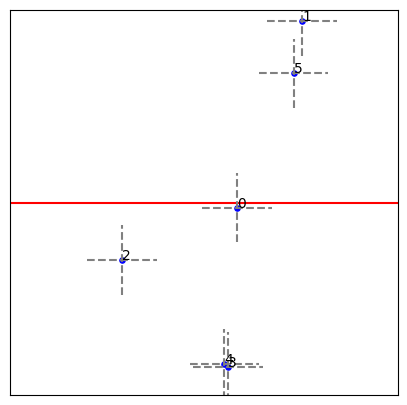

In [15]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
PlotCopy(R_i[:,0],Lx,Ly,region_geometry,boundary,step_size,ax, color='blue')

In [16]:
InsideRegion(Lx,Ly,R_i[:,1],region_geometry,boundary)

array([False, False,  True,  True,  True,  True])

In [17]:
swap_order_i, swap_R_i, where_moves = LocateParticlesSWAP(Lx, Ly, R_i, region_geometry, boundary, step_size)

In [18]:
where_moves[:,1,:]

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

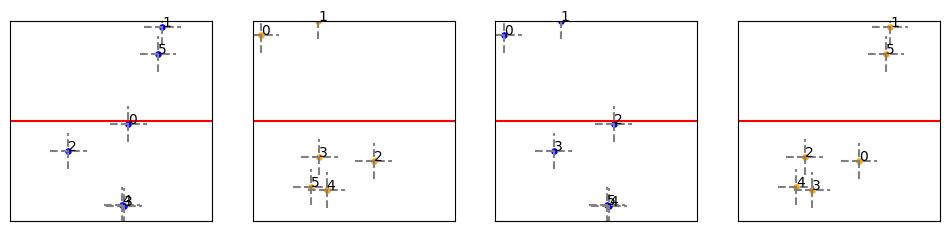

In [19]:
PlotSystem(R_i, Lx, Ly, region_geometry, boundary, step_size, swap_R_i)

In [20]:
inside_A = InsideRegion(Lx,Ly,R_i,'strip',boundary)

In [21]:
swap_order_i

array([[-3, -1],
       [ 2, -2],
       [-4,  1],
       [-5,  3],
       [-6,  4],
       [ 6,  5]], dtype=int8)

In [22]:
map_to_swap, map_from_swap = AssignOrderSwap(inside_A)
print(map_to_swap)
print(map_from_swap)

[[ 2  0]
 [ 7  1]
 [ 3  6]
 [ 4  8]
 [ 5  9]
 [11 10]]
[[ 6  8]
 [ 7  1]
 [ 0  9]
 [ 2 10]
 [ 3 11]
 [ 4  5]]


In [25]:
map_to_swap.reshape(1,-1)

array([[ 2,  0,  7,  1,  3,  6,  4,  8,  5,  9, 11, 10]], dtype=uint8)

In [26]:
np.ravel(map_to_swap, order='F')[np.ravel(map_from_swap, order='F')]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8)

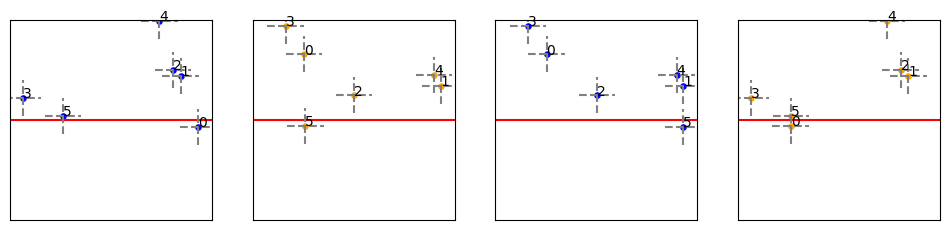

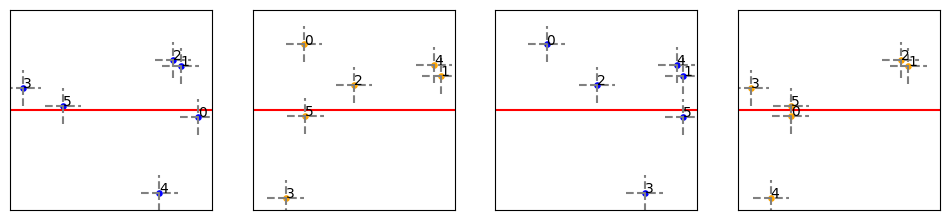

In [58]:
R_f, p, delta = StepOneSWAPRandom(
                Lx, Ly, t, step_size, R_i, where_moves)
swap_order_f, swap_R_f = UpdateOrderSWAP(R_f, swap_order_i, swap_R_i, p, delta[0], where_moves[:,0,:])
while np.count_nonzero(InsideRegion(Lx,Ly,R_f[:,0],region_geometry, boundary)) == 1:
        R_f, p, delta = StepOneSWAPRandom(
                Lx, Ly, t, step_size, R_i, where_moves)
        swap_order_f, swap_R_f = UpdateOrderSWAP(R_f, swap_order_i, swap_R_i, p, delta[0], where_moves[:,0,:])

PlotSystem(R_i, Lx, Ly, region_geometry, boundary, step_size, swap_R_i)
PlotSystem(R_f, Lx, Ly, region_geometry, boundary, step_size, swap_R_f)

In [61]:
R_i = np.copy(R_f)
for i in range(2):
    TrackParticleMoves(R_i, p[i], i, where_moves, Lx, Ly,
                                   region_geometry, boundary, step_size)

In [63]:
where_moves[:,0,:]

array([[ 0,  0, -1,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0, -1],
       [ 0,  0,  0,  1]], dtype=int8)